# Challenge 1

In this challenge you create a circuit having training blocks and encoding blocks. 
Finally you measure only one qubit.

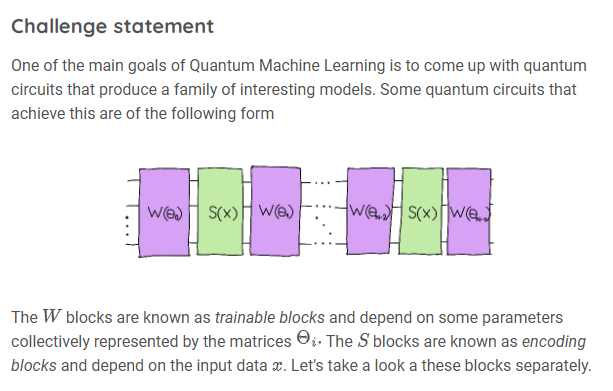


In [1]:
#!pip install pennylane

In [124]:
import json
import pennylane as qml
import pennylane.numpy as np


import matplotlib.pyplot as plt

import math

## create a function making a layer of trainable block

In [304]:
def W(params):
    
    """
    Subcircuit that implements the trainable block W
    
    Args:
        params (np.array): A matrix containing the parameters for the trainable block W. The length of
        params is equal to the depth of the circuit. The length of each row in params is the number 
        of qubits used. See the challenge statement for a detailed explanation
    Returns:
        Since this function is a subcircuit, you must not return anything.
    
    """
    # Put your code here
    #p = params[0]
    n_layers = params.shape[0]
    n_qubits = params.shape[1]
    for i_layer in range(n_layers):
        for i_qubit in range(n_qubits):
            qml.RY(params[i_layer][i_qubit], wires = i_qubit)
        if n_qubits > 1:
            for i_qubit in range(n_qubits - 1):
                qml.CNOT(wires=[i_qubit, i_qubit + 1])
            qml.CNOT(wires=[n_qubits - 1, 0])
    

In [305]:
params=np.array([[[0.5,2,2],[1,2,2]],[[0.5,2,2],[1,2,2]]])
params[0][0][0]

tensor(0.5, requires_grad=True)

C:\Users\Oleg\AppData\Local\Temp\ipykernel_21388\2871483251.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


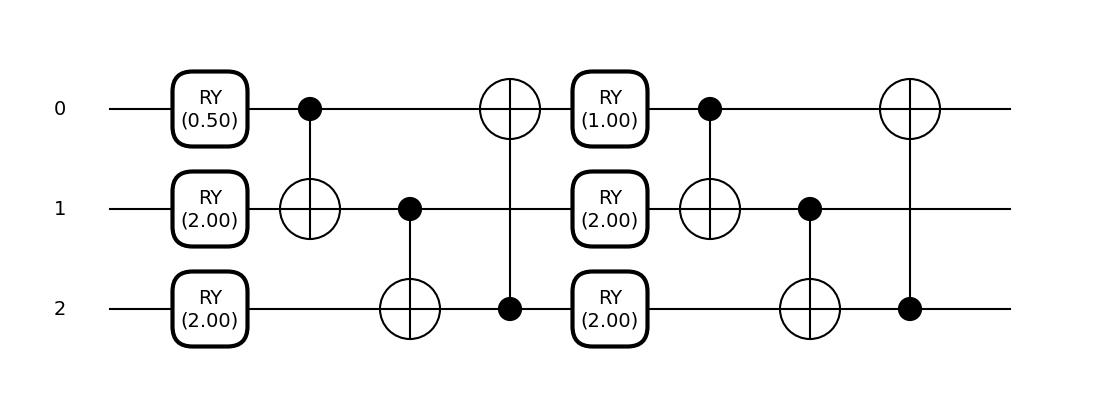

In [306]:
import matplotlib.pyplot as plt
fig, ax = qml.draw_mpl(W, decimals=2)(params[0])
fig.show()

## Create a function making an encoding block

In [394]:
def S(g, x, bit_size):
    qml.registers({"q_reg": bit_size})
    for i in range(bit_size):
        qq = g(i) #a = 1#
        qml.exp(qq, coeff = 1j * x)
    #Use the lines below to add measurement to the circuit
    #ret = []    
    #for i in range(bit_size):
    #    ret.append(qml.expval(qml.PauliZ(i)))
    #return ret

## Create the whole quantum circuit

In [395]:
dev = qml.device("default.qubit", wires = 4)

@qml.qnode(dev)
def quantum_model(param_set, g, x):
    """
    This QNode implements the quantum model with alternating trainable and encoding blocks
    
    Args:
        param_set (np.array): A numpy array whose elements are the parameter matrices for each of the trainable
        blocks. Therefore, the length of this list is equal to the number of trainable blocks, which is greater
        than, or equal to 2.
        g (pennylane.Operator): A PennyLane operator representing the generator for the encoding
        gates. It must be Hermitian in order to generate a unitary.
        x: The scalar coefficient of the operator g.
    Returns:
        (np.tensor(float)): A tensor of dimensions (2,) representing the measurement probabilities in the computational 
        basis on the first wire.
    """
    n_blocks = param_set.shape[0]
    n_qubits = param_set.shape[2]
    for i_block in range(n_blocks-1):
        params = param_set[i_block]
        W(params)
        S(g, x, n_qubits)
    params = param_set[n_blocks-1]
    W(params)
    return qml.probs(wires = [0])

In [396]:
dev = qml.device("default.qubit", wires = 4)
params = np.array([[[1.0472, 0.7854, 3.1416, 0.3927], [1.0472, 0.7854, 3.1416, 0.5236]], [[2.0472, 2.7854, 3.1416, 0.3927], [1.0472, 0.7854, 3.1416, 0.5236]]])
g = getattr(qml, 'PauliX')
x = 0.7854
rr = quantum_model(params, g, x)
rr

tensor([0.62400988, 0.37599012], requires_grad=True)

C:\Users\Oleg\AppData\Local\Temp\ipykernel_21388\3269798245.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


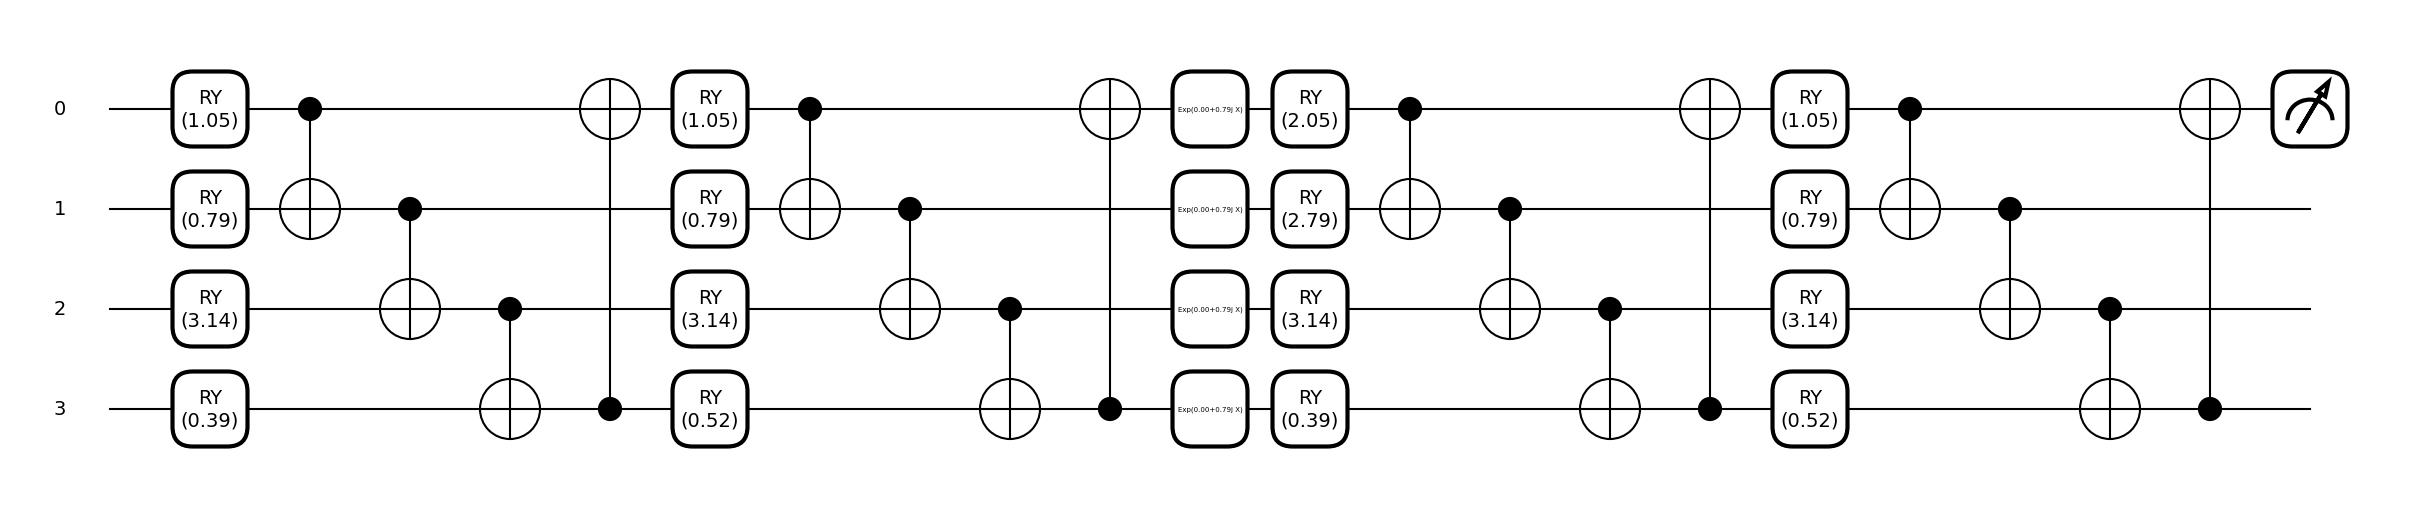

In [397]:
g = getattr(qml, 'PauliX')
params = np.array([[[1.0472, 0.7854, 3.1416, 0.3927], [1.0472, 0.7854, 3.1416, 0.5236]], [[2.0472, 2.7854, 3.1416, 0.3927], [1.0472, 0.7854, 3.1416, 0.5236]]])
fig, ax = qml.draw_mpl(quantum_model, decimals=2)(params, g, x)
fig.show()

## Test case functions for Challege 1

In [398]:
def run(test_case_input: str) -> str:
    ins = json.loads(test_case_input)
    params = np.array(ins[0])
    g = getattr(qml, ins[1])
    x = ins[2]
    outs = str(quantum_model(params, g, x))
    outs_1 = outs.split(' ')
    outs_fin = outs_1[0] + ', ' + outs_1[1]
    return outs_fin

def check(solution_output: str, expected_output: str) -> None:
    solution_output = json.loads(solution_output)
    expected_output = json.loads(expected_output)
    
    dev_test = qml.device("default.qubit", wires = [0,1,2])    
    
    @qml.qnode(dev_test)
    def w_node(params):
        
        W(params)
        
        return qml.probs(wires = [0,1]) 
    
    @qml.qnode(dev_test)
    def s_node(g, x, num_wires):
        
        S(g, x, num_wires)
        
        return qml.probs(wires = [0,1]) 
        
    params_test = np.array([[np.pi, np.pi/4, np.pi],[np.pi, np.pi/4, np.pi/3]])
    w_test = w_node(params_test)
    
    s_test = s_node(qml.PauliX, np.pi/7, 3)
    
    assert np.allclose(w_test, [0.10983496, 0.21338835, 0.03661165, 0.64016504], atol = 1e-3), "Something isn't quite right with the trainable block."
    
    assert np.allclose(s_test, [0.65892978, 0.15281512, 0.15281512, 0.03543998], atol = 1e-3), "Something isn't quite right with the encoding block."
    
    assert np.allclose(solution_output,expected_output, atol = 1e-3), "Not the correct probabilities for the quantum model."


In [399]:
test_input = '[[[[1.0472, 0.7854, 3.1416, 0.3927],[1.0472, 0.7854, 3.1416, 0.5236]],[[1.0472, 0.7854, 1.5708, 0.3927],[0.7854, 0.7854, 1.5708, 0.7854]]],"PauliX", 0.7854]'

solution_output = run(test_input)
print(solution_output)

#solution_output = json.loads(solution_output) 
#print(test_input)

[0.46652954, 0.53347046]


In [400]:
test_cases = [
    ('[[[[1.0472, 0.7854, 3.1416, 0.3927],[1.0472, 0.7854, 3.1416, 0.5236]],[[1.0472, 0.7854, 1.5708, 0.3927],[0.7854, 0.7854, 1.5708, 0.7854]]],"PauliX", 0.7854]', '[0.46653, 0.53347]'),
    ('[[[[0.62832, 0.3927, 1.0472, 0.7854],[0.7854, 0.31416, 0.62832, 0.5236]],[[0.31416, 0.7854, 0.7854, 0.3927],[0.31416, 0.3927, 0.31416, 0.3927]]],"PauliY", 0.5236]', '[0.68594, 0.31406]')
]

In [401]:
for i, (input_, expected_output) in enumerate(test_cases):
    print(input_)

    try:
        output = run(input_)
        print(output)

    except Exception as exc:
        print(f"Runtime Error. {exc}")

    else:
        if message := check(output, expected_output):
            print(f"Wrong Answer. Have: '{output}'. Want: '{expected_output}'.")

        else:
            print("Correct!")

[[[[1.0472, 0.7854, 3.1416, 0.3927],[1.0472, 0.7854, 3.1416, 0.5236]],[[1.0472, 0.7854, 1.5708, 0.3927],[0.7854, 0.7854, 1.5708, 0.7854]]],"PauliX", 0.7854]
[0.46652954, 0.53347046]
Correct!
[[[[0.62832, 0.3927, 1.0472, 0.7854],[0.7854, 0.31416, 0.62832, 0.5236]],[[0.31416, 0.7854, 0.7854, 0.3927],[0.31416, 0.3927, 0.31416, 0.3927]]],"PauliY", 0.5236]
[0.68594115, 0.31405885]
Correct!
